In [53]:
#! pip install -r requirements.txt
#! pip install --force-reinstall -r requirements.txt

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torchsummary import summary
import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

from PIL import Image, ImageOps
from IPython.display import clear_output
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import plotly.express as px

# from dataset import MyData
# from model import Net
from make_gif_from_folder import make_gif

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(0)
print(device)

cuda:0


In [2]:
class MyData(torch.utils.data.Dataset):
    def __init__(self, path_to_file, mode, radius, reduce_fctor=1, need_help=False, need_info=False):
        self.need_help = need_help
        self.radius = radius
        self.maps_markup = self.make_markup()
        self.reduce_factor = reduce_fctor
        self.img_array = self.get_img_array(path_to_file) if mode == 'img' else self.read_from_abz(path_to_file)
        self.width, self.height = self.img_array.shape
        self.total_pixel = self.width * self.height
        self.bound_length = len(np.where(self.img_array < 255)[0])
        self.data_2d, self.data_3d = self.make_data()
        self.data_3d.x, self.data_3d.y, self.data_3d.z = self.data_3d[:, 0], self.data_3d[:, 1], self.data_3d[:, 2]
        if need_info:
            print(f'width: {self.width}\n' +
                  f'height: {self.height}\n' +
                  f'total_pixel: {self.total_pixel}\n' +
                  f'bound length: {self.bound_length}\n' +
                  f'percent of bound pixels: {(100 * self.bound_length / self.total_pixel):.1f}%')

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data_2d[idx], self.data_3d[idx]

    def get_img_array(self, path_to_file):
        return np.array(ImageOps.grayscale(Image.open(path_to_file))).astype(int)
        
    def make_data(self):
        data_2d = torch.from_numpy(np.stack(np.indices((self.width, self.height)), axis=2).reshape(-1, 2)).float()
        x, y = data_2d[:, 0], data_2d[:, 1]
        x -= x.mean()
        x /= x.abs().max()
        y -= y.mean()
        y /= y.abs().max()
        data_2d = torch.stack((x, y), dim=1)
        z = x
        x = torch.cos(torch.pi * y) * (1 - z.pow(2)).pow(0.5)
        y = torch.sin(torch.pi * y) * (1 - z.pow(2)).pow(0.5)
        data_3d = self.radius * torch.stack((x, y, z), dim=1)
        return data_2d, data_3d

    def make_markup(self):
        res = {}
        current = 0
        with open("./data/CL_23.txt", "r", encoding='windows-1251') as file:
            for line in file:
                try:
                    temp = list(map(int, line.rstrip().split()))
                except:
                    continue
                if len(temp) == 1:
                    current = temp[0]
                elif len(temp) == 0:
                    continue
                else:
                    if current not in res.keys():
                        res[current] = [temp[1:]] 
                    else:
                        res[current].append(temp[1:])
        return res

    def show_image(self):
        plt.figure(figsize=(10, 5))
        plt.title('Input Image')
        plt.imshow(self.img_array, cmap='gray', vmin=0, vmax=255)
    
    def read_from_abz(self, filename):
        with open(filename) as f:
            lines = [line.rstrip() for line in f]
        my_shape = [int(x) for x in lines[0].split()[-6:-4]]
        my_shape.reverse()
        img_array = np.full(shape=my_shape, fill_value=255)
        for line in lines[3:]:
            line = [int(x) for x in line.split()]
            if len(line) == 3:
                y = line[0]
                x1 = line[1]
                x2 = -line[2]
                for i in range(x1, x2 + 1):
                    img_array[min(y, my_shape[0] - 1), min(i, my_shape[1] - 1)] = 0
            elif len(line) == 5:
                y = line[0]
                x1 = line[1]
                x2 = -line[2]
                x3 = line[3]
                x4 = -line[4]
                for i in range(x1, x2 + 1):
                    img_array[min(y, my_shape[0] - 1), min(i, my_shape[1] - 1)] = 0
                for i in range(x3, x4 + 1):
                    img_array[min(y, my_shape[0] - 1), min(i, my_shape[1] - 1)] = 0
        if self.need_help:
            map_number = int(filename[-11:-7])
            i = 10
            for line in self.maps_markup[map_number]:    
                for el in line:
                    x, y = int(el * (my_shape[0] - 1) / 180.), int(i * (my_shape[1] - 1) / 360.)
                    img_array[x, y] = 0
                    img_array[min(x + 1, my_shape[0] - 1), y] = 0
                    img_array[max(x - 1, 0), y] = 0
                    img_array[x, min(y + 1, my_shape[1] - 1)] = 0
                    img_array[x, max(y - 1, 0)] = 0
                i += 10
        return img_array

    def show_3d_static(self):
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(self.data_3d.x, self.data_3d.y, self.data_3d.z, c=self.img_array.flatten())

    def show_3d(self):
        df = pd.DataFrame({'x': self.data_3d.x[::self.reduce_factor], 
                            'y': self.data_3d.y[::self.reduce_factor], 
                            'z': -self.data_3d.z[::self.reduce_factor], 
                            'label': self.img_array.flatten()[::self.reduce_factor]})
        return px.scatter_3d(df, x='x', y='y', z='z', color='label').update_traces(marker={'size': 2})

In [63]:
class Net(nn.Module):
    def __init__(self, dataset1, dataset2, lr, weight_decay=1e-3):
        super(Net, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(3, 6), nn.ELU(),
            nn.Linear(6, 12), nn.ELU(),
            nn.Linear(12, 24), nn.ELU(),
            nn.Linear(24, 1), nn.Tanh())
        # self.weight = torch.nn.Parameter(torch.FloatTensor([1]), requires_grad=True)
        self.dataset1 = dataset1
        self.dataset2 = dataset2
        self.lr = lr
        self.weight_decay = weight_decay
        self.optimizer = torch.optim.Adam(self.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        #scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', verbose=True, patience=100)        
        self.loss_dict = {'loss': [],
                          'f_abs_integral': [],
                          'bound_integral': [],
                          'orientation_integral': [],
                          'f_integral': []}
        
    def forward(self, x):
        #x = x.to(device)
        output = self.net(x)
        return output
    
    # def compute_and_plot_gradient(self, prediction):
    #     batch = self.dataset.data_3d
    #     batch.requires_grad_()
    #     tmp = self(batch.to(device))
    #     tmp.sum().backward()
    #     grad_out = batch.grad.cpu()
    #     plt.figure(figsize=(12, 6))
    #     plt.title(r'Gradient map for $||\nabla f(x,y,z)||_2$', fontsize=30)
    #     plt.imshow(((grad_out.pow(2).sum(dim=1)).pow(0.5)).view(self.dataset.img_array.shape), cmap='plasma')
    #     plt.colorbar()
    #     return grad_out

    def show_on_cylinder(self, prediction):
        x, y, z = torch.cat((self.dataset1.data_3d.x, self.dataset2.data_3d.x)), torch.cat((self.dataset1.data_3d.y, self.dataset2.data_3d.y)), torch.cat((self.dataset1.data_3d.z, self.dataset2.data_3d.z))
        df = pd.DataFrame({'x': x.cpu().detach().numpy(),
                            'y': y.cpu().detach().numpy(),
                            'z': -z.cpu().detach().numpy(),
                            'label': prediction.flatten()})
        return px.scatter_3d(df, x='x', y='y', z='z', color='label').update_traces(marker={'size': 2})

    def show_loss_items(self):
        plt.figure(figsize=(12, 6))
        plt.subplot(2, 2, 1)
        plt.xlabel('Epoch')
        plt.ylabel('f_abs_integral')
        plt.plot(self.loss_dict['f_abs_integral'])

        plt.subplot(2, 2, 2)
        plt.xlabel('Epoch')
        plt.ylabel('bound_integral')
        plt.plot(self.loss_dict['bound_integral'])

        plt.subplot(2, 2, 3)
        plt.xlabel('Epoch')
        plt.ylabel('orientation_integral')
        plt.plot(self.loss_dict['orientation_integral'])

        plt.subplot(2, 2, 4)
        plt.xlabel('Epoch')
        plt.ylabel('f_integral')
        plt.plot(self.loss_dict['f_integral'])
        plt.show()
        
    def change_lr(self, lr):
        for g in self.optimizer.param_groups:
            g['lr'] = lr

    def restart_model(self, lr, weight_decay=1e-3):
        model = Net(dataset1=self.dataset1, dataset2=self.dataset2, lr=lr, weight_decay=weight_decay)
        model.to(device)
        return model

    def save_state_dict(self, path):
        torch.save(self.state_dict(), path)

    def test_model(self, input, need_plot=False):
        with torch.no_grad():
            output = self(input.to(device)).cpu().detach()
        if need_plot:
            plt.figure(figsize=(12, 6))
            plt.subplot(1, 2, 1)
            plt.title('Visualization of the function $f(x,y,z)$\n on first map')
            plt.imshow(output[:self.dataset1.total_pixel].view(self.dataset1.img_array.shape), cmap='PuOr', vmin=-1, vmax=1) 
            plt.subplot(1, 2, 2)
            plt.title('Visualization of the function $f(x,y,z)$\n on second map')
            plt.imshow(output[-self.dataset2.total_pixel:].view(self.dataset2.img_array.shape), cmap='PuOr', vmin=-1, vmax=1) 
        return output

    def start_training(self, num_epochs, my_weight=1e-1, show_frequency=1e+2):
        for _, value in self.loss_dict.items():
            value.clear()
        batch = torch.cat((self.dataset1.data_3d, self.dataset2.data_3d))
        perm = torch.randperm(self.dataset1.total_pixel + self.dataset2.total_pixel)
        inv_perm = torch.argsort(perm)
        batch = batch[perm].to(device)
        dir_path = 'epoch_outs'
        if not os.path.exists(dir_path):
            os.mkdir(dir_path)
        for epoch in range(1, int(num_epochs) + 1):
            output = self(batch)[inv_perm]
            self.optimizer.zero_grad()
            loss = self.compute_loss(output=output, my_weight=my_weight)
            loss.backward(retain_graph=True)
            self.optimizer.step()
            # scheduler.step(loss)
            if epoch % int(show_frequency) == 0:
                output = output.cpu().detach().numpy()
                output1, output2 = output[:self.dataset1.total_pixel].reshape(self.dataset1.img_array.shape), output[-self.dataset2.total_pixel:].reshape(self.dataset2.img_array.shape)
                clear_output(wait=True)
                gs = gridspec.GridSpec(2, 3)
                fig = plt.figure(figsize=(16, 6))

                ax1 = fig.add_subplot(gs[:, 0])
                ax1.set_xlabel('Epoch')
                ax1.set_ylabel('Loss')
                ax1.plot(self.loss_dict['loss'])

                ax2 = fig.add_subplot(gs[0, 1])
                ax2.title.set_text('Carrington Rotation №1904')
                ax2.get_xaxis().set_ticks([])
                ax2.get_yaxis().set_ticks([])
                ax2.imshow(output1, cmap='PuOr', vmin=-1, vmax=1)

                ax3 = fig.add_subplot(gs[0, 2])
                ax3.title.set_text('Carrington Rotation №1905')
                ax3.get_xaxis().set_ticks([])
                ax3.get_yaxis().set_ticks([])
                ax3.imshow(output2, cmap='PuOr', vmin=-1, vmax=1)
                
                ax4 = fig.add_subplot(gs[1, 1])
                ax4.get_xaxis().set_ticks([])
                ax4.get_yaxis().set_ticks([])
                ax4.title.set_text('Input image 1904')
                ax4.imshow(self.dataset1.img_array, cmap='gray')

                ax5 = fig.add_subplot(gs[1, 2])
                ax5.get_xaxis().set_ticks([])
                ax5.get_yaxis().set_ticks([])
                ax5.title.set_text('Input image 1905')
                ax5.imshow(self.dataset2.img_array, cmap='gray')
                
                plt.savefig(dir_path + '/epoch%06d.png' % epoch)
                plt.show()

    def compute_loss(self, output): #WEIGHT FOR SECOND LOSS
        loss, f_abs_integral, bound_integral, orientation_integral, f_integral = torch.zeros(5)
        output_list = [output[:self.dataset1.total_pixel], output[-self.dataset2.total_pixel:]]
        dataset_list = [self.dataset1, self.dataset2]
        for (output, dataset) in zip(output_list, dataset_list):
            mask = np.where(dataset.img_array.reshape(-1, 1) == 255)[0]
            bound_mask = np.where(dataset.img_array.reshape(-1, 1) < 255)[0]
            row_numbers = 1 * dataset.height
            upper_bound = (output[:row_numbers].sum() / len(output[:row_numbers]) - 1).abs()
            lower_bound = (output[-row_numbers:].sum() / len(output[-row_numbers:]) + 1).abs()

            f_abs_integral_ = f_abs_integral.clone()
            orientation_integral_ = orientation_integral.clone()
            f_integral_ = f_integral.clone()
            bound_integral_ = bound_integral.clone()
            loss_ = loss.clone()
            
            f_integral = f_integral_ + my_weight * output.sum().abs() / dataset.total_pixel
            orientation_integral = orientation_integral_ + (upper_bound + lower_bound) / 4.
            f_abs_integral = f_abs_integral_ + 1 - output[mask].abs().sum() / (dataset.total_pixel - dataset.bound_length) # хочу НЕ границу +-1
            bound_integral = bound_integral_ + (output[bound_mask].pow(2).sum() / dataset.bound_length) # хочу на границе 0
            loss = loss_ + f_abs_integral + bound_integral + orientation_integral + f_integral
            
        self.loss_dict['loss'].append(loss.item())
        self.loss_dict['f_abs_integral'].append(f_abs_integral.item())
        self.loss_dict['bound_integral'].append(bound_integral.item())
        self.loss_dict['orientation_integral'].append(orientation_integral.item())
        self.loss_dict['f_integral'].append(f_integral.item())
        return loss
        # w_bound = torch.sigmoid(self.weight)
        # w_abs = 1 - w_bound
        # return (w_abs + 1) * f_abs_integral + (w_bound + 1) * bound_integral + orientation_integral, w_bound

In [73]:
dataset1=MyData(path_to_file='./imgs/fun1.png', mode='img', radius=2, reduce_fctor=1, need_help=False)
dataset2=MyData(path_to_file='./imgs/fun2.png', mode='img', radius=4, reduce_fctor=1, need_help=False)
# dataset.show_3d()

In [65]:
model = Net(dataset1=dataset1, dataset2=dataset2, lr=1e-2)
model.to(device)
# summary(model, (1, 3))
# model.load_state_dict(torch.load('./1904_low_low2_1e-3_state_dict.pt'))

Net(
  (net): Sequential(
    (0): Linear(in_features=3, out_features=6, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=6, out_features=12, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=12, out_features=24, bias=True)
    (5): ELU(alpha=1.0)
    (6): Linear(in_features=24, out_features=1, bias=True)
    (7): Tanh()
  )
)

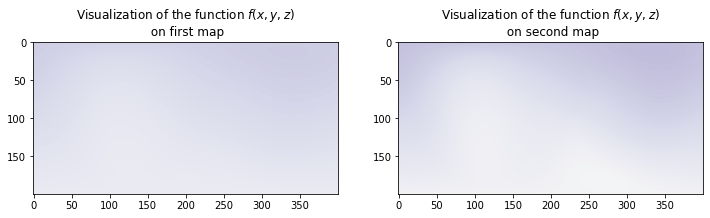

In [66]:
prediction = model.test_model(torch.cat((dataset1.data_3d, dataset2.data_3d)), need_plot=True)

In [ ]:
model.show_on_cylinder(prediction=prediction)

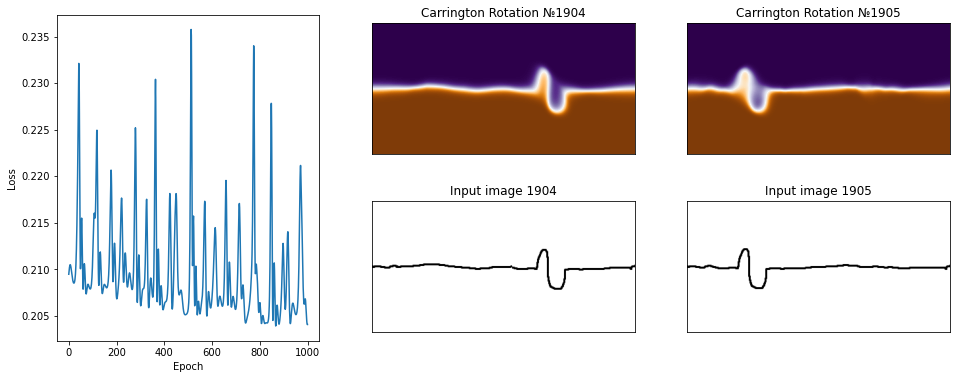

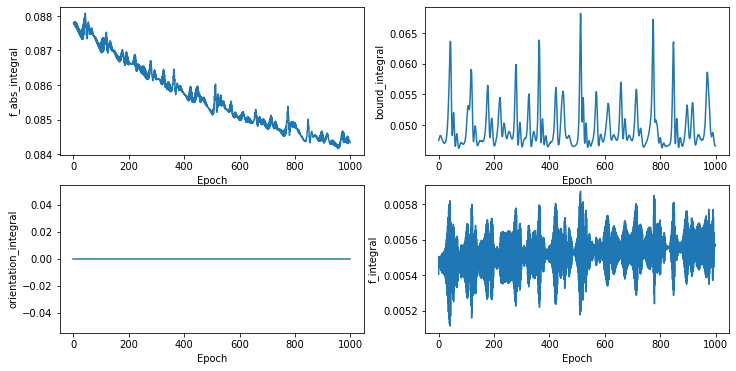

In [69]:
# model.change_lr(1e-3)
# model = model.restart_model(lr=1e-3)
model.start_training(num_epochs=1e+3, my_weight=0.1)
model.show_loss_items()

In [ ]:
# model.save_state_dict('./1905_low_low_1e-2_state_dict.pt')

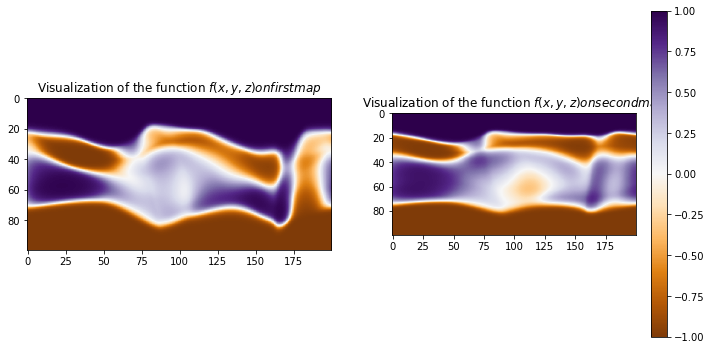

In [26]:
output = model.test_model(torch.cat((dataset1.data_3d, dataset2.data_3d)), need_plot=True)

In [27]:
grad_out = model.compute_and_plot_gradient(output)

AttributeError: 'Net' object has no attribute 'compute_and_plot_gradient'

In [ ]:
model.show_on_cylinder(prediction=output)

In [ ]:
make_gif(dir_path='./epoch_outs', gifname='nice')

In [ ]:
plt.imsave('output.png', dataset.img_array, cmap='gray')

In [ ]:
data_2d = torch.from_numpy(np.stack(np.indices((dataset.width, dataset.height)), axis=2).reshape(-1, 2)).float()
data_2d[:, 0] -= data_2d[:, 0].mean()
data_2d[:, 0] /= data_2d[:, 0].abs().max()
data_2d[:, 1] -= data_2d[:, 1].mean()
data_2d[:, 1] /= data_2d[:, 1].abs().max()
data_3d = torch.stack((7 * torch.cos(torch.pi * data_2d[:, 1]), torch.sin(7 * torch.pi * data_2d[:, 1]), 1 * data_2d[:, 0]), dim=1)

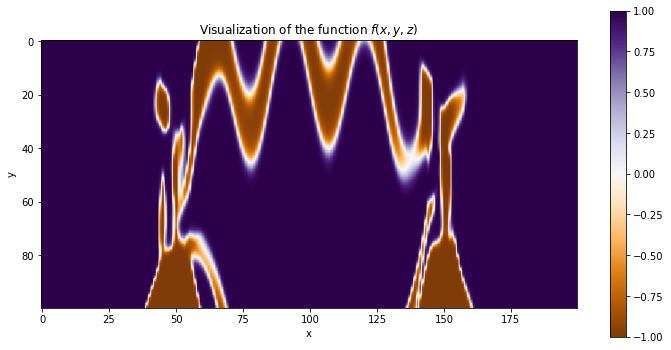

In [ ]:
input = data_3d
output = model.test_model(input, need_plot=True)

In [ ]:
a = dataset.data_3d

In [ ]:
a = torch.arange(12).view(-1, 2)

In [ ]:
a

tensor([[ 0,  1],
        [ 2,  3],
        [ 4,  5],
        [ 6,  7],
        [ 8,  9],
        [10, 11]])

In [ ]:
b = -a

In [ ]:
b

tensor([[  0,  -1],
        [ -2,  -3],
        [ -4,  -5],
        [ -6,  -7],
        [ -8,  -9],
        [-10, -11]])

In [ ]:
torch.cat((a, b))[-9:]

tensor([[  6,   7],
        [  8,   9],
        [ 10,  11],
        [  0,  -1],
        [ -2,  -3],
        [ -4,  -5],
        [ -6,  -7],
        [ -8,  -9],
        [-10, -11]])

In [ ]:
batch = torch.cat((dataset1.data_3d, dataset2.data_3d))

In [ ]:
a = batch.to(device)

In [ ]:
a

tensor([[-5.0000e-01,  4.3711e-08, -1.0000e+00],
        [-4.9975e-01, -1.5784e-02, -1.0000e+00],
        [-4.9900e-01, -3.1553e-02, -1.0000e+00],
        ...,
        [-9.9801e-01,  6.3106e-02,  1.0000e+00],
        [-9.9950e-01,  3.1568e-02,  1.0000e+00],
        [-1.0000e+00, -8.7423e-08,  1.0000e+00]], device='cuda:0')

In [ ]:
batch = torch.cat((dataset1.data_3d, dataset2.data_3d))

perm = torch.randperm(dataset1.total_pixel + dataset2.total_pixel)
inv_perm = torch.argsort(perm)
batch = batch[perm]

In [ ]:
batch

tensor([[-0.4938,  0.0786, -0.8586],
        [-0.1515,  0.4765,  0.7778],
        [-0.9821, -0.1883, -0.7576],
        ...,
        [ 0.1650,  0.9863, -0.6364],
        [-0.7881,  0.6155,  0.2727],
        [ 0.4616,  0.1923, -0.5758]])

In [ ]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'


In [ ]:
batch.to(device)

tensor([[-0.4938,  0.0786, -0.8586],
        [-0.1515,  0.4765,  0.7778],
        [-0.9821, -0.1883, -0.7576],
        ...,
        [ 0.1650,  0.9863, -0.6364],
        [-0.7881,  0.6155,  0.2727],
        [ 0.4616,  0.1923, -0.5758]], device='cuda:0')

In [ ]:
dataset1.total_pixel

20000

In [ ]:
dataset2.total_pixel

20000

In [ ]:
a = torch.arange(2)
b = torch.arange(2, 4)

In [ ]:
for (x, y) in zip(a, b):
    print(x, y)

tensor(0) tensor(2)
tensor(1) tensor(3)


In [71]:
MyData.make_data(MyData, radius=2)

AttributeError: type object 'MyData' has no attribute 'width'

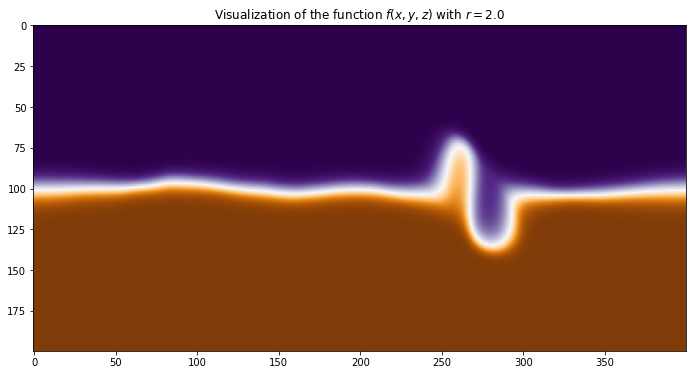

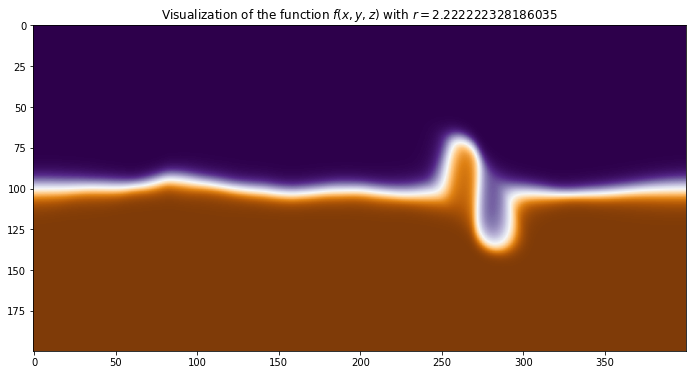

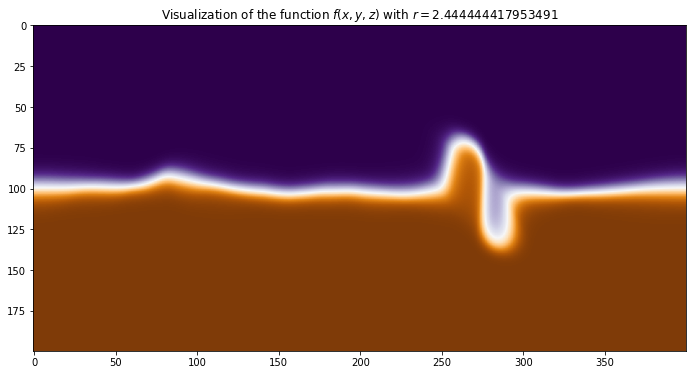

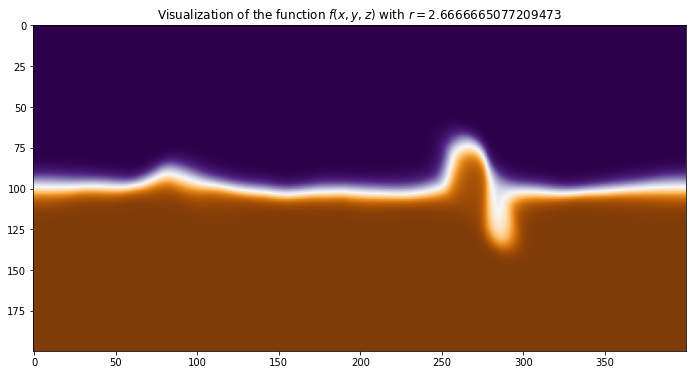

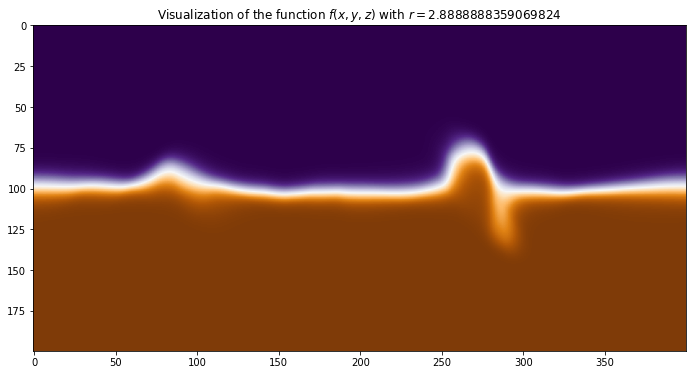

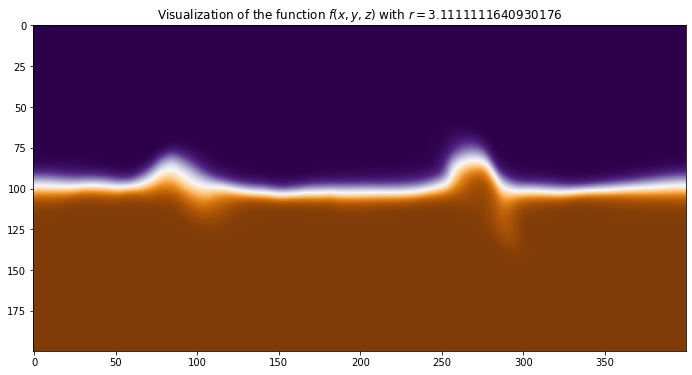

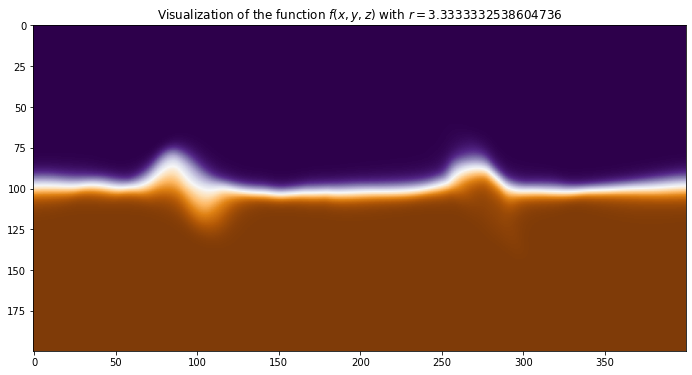

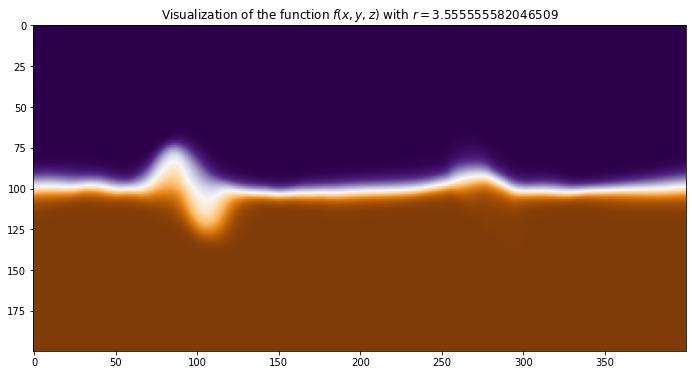

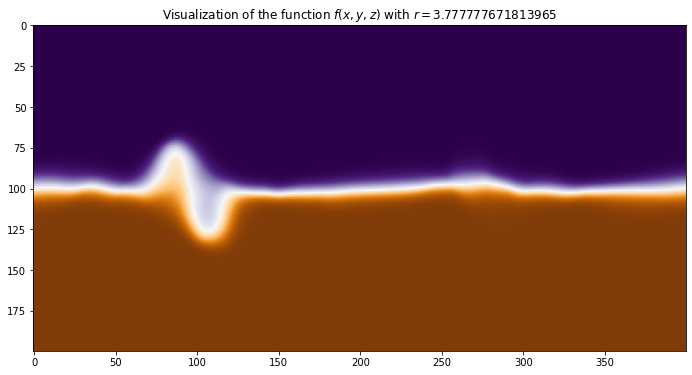

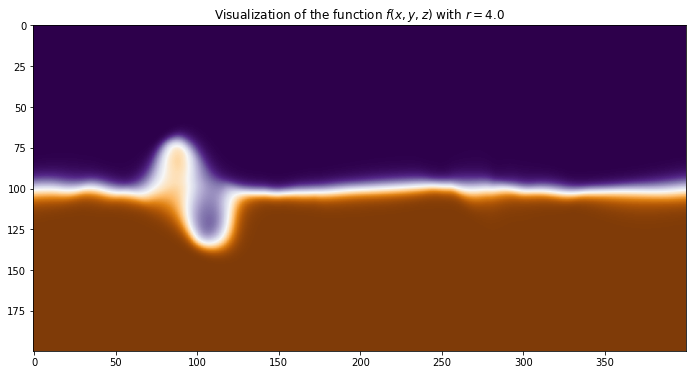

In [76]:
for i in torch.linspace(0, 1, steps=10):
    batch = i * dataset2.data_3d + (1 - i) * dataset1.data_3d 
    prediction = model.test_model(batch)
    plt.figure(figsize=(12, 6))
    plt.title(f'Visualization of the function $f(x,y,z)$ with $r={i * dataset2.radius + (1 - i) * dataset1.radius }$')
    plt.imshow(prediction.view(dataset1.img_array.shape), cmap='PuOr', vmin=-1, vmax=1)